Mendownload Dataset dari kaggle lewat API

In [ ]:
!pip install -q --upgrade kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset

 99% 1.24G/1.26G [00:16<00:00, 69.2MB/s]
100% 1.26G/1.26G [00:16<00:00, 83.5MB/s]


In [ ]:
!unzip -q bottle-synthetic-images-dataset.zip

Mengimport module yang dibutuhkan

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from keras.models import Sequential as sq
from keras.layers import *
from keras.callbacks import Callback
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
from PIL import Image
import os

Load Data dari direktori

In [ ]:
base_dir = '/content/Bottle Images/Bottle Images/'

In [ ]:
os.listdir(base_dir)

['Plastic Bottles',
 'Water Bottle',
 'Wine Bottle',
 'Soda Bottle',
 'Beer Bottles']

In [ ]:
resolutions = []

for root, _, files in os.walk(base_dir):
    for filename in files:
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(root, filename)

            try:
                image = Image.open(image_path)
            except Exception as e:
                print(f"Error opening image {image_path}: {e}")
                continue

            width, height = image.size

            resolutions.append((width, height))

print("Image resolutions:")
for resolution in resolutions:
    print(f"- {resolution[0]}x{resolution[1]}")


In [ ]:
tf.keras.utils.image_dataset_from_directory(base_dir)

Found 25000 files belonging to 5 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Preprocessing image

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./ 255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split = 0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    shuffle=True,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    shuffle=False,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [ ]:
class_names = {value: key for key, value in train_generator.class_indices.items()}
class_names

{0: 'Beer Bottles',
 1: 'Plastic Bottles',
 2: 'Soda Bottle',
 3: 'Water Bottle',
 4: 'Wine Bottle'}

Visualisasi data

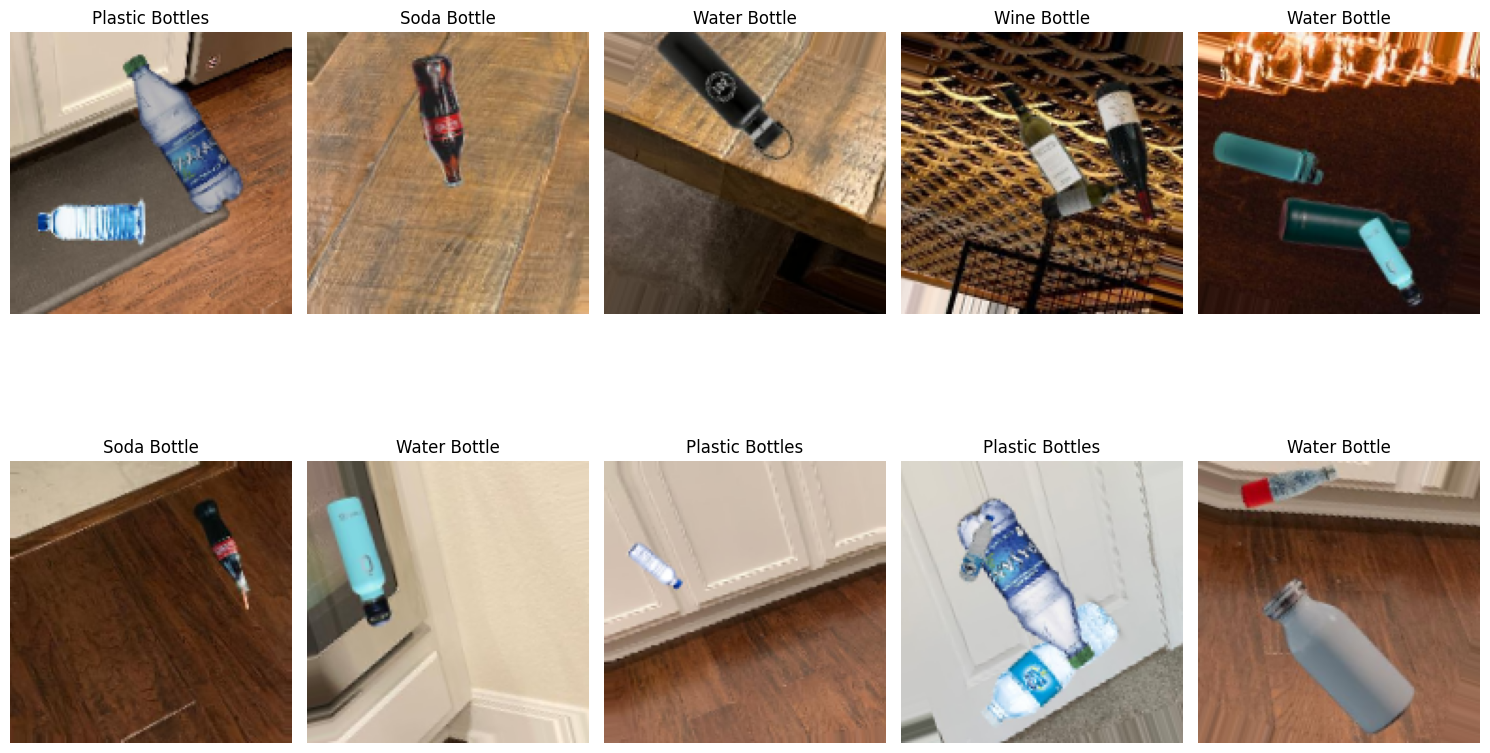

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 10))
idx=0

for i in range(2):
  for x in range(5):
        classes = class_names[np.argmax(train_generator[0][1][idx])]
        ax[i, x].set_title(f"{classes}")
        ax[i, x].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, x].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

Membuat model menggunakan arsitektur Efficient Net V2

In [ ]:
base_model = EfficientNetV2B0(
    include_top = False,
    input_shape = (150, 150, 3),
    weights = 'imagenet'
)

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model = sq()

model.add(base_model)
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=2, strides=(2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 5, 5, 1280)        5120      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 32)          163872    
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 32)          0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 32)          128       
 chNormalization)                                       

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class CustomCallback(Callback):
  def on_epoch_end(self, epochs, logs=None):
    val_acc = logs.get('val_accuracy')
    acc = logs.get('accuracy')
    if val_acc > 0.94 and acc > 0.94:
      self.model.stop_training = True

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=25,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [CustomCallback()]
)

Epoch 1/25
625/625 [==============================] - 218s 271ms/step - loss: 0.7413 - accuracy: 0.7153 - val_loss: 0.3457 - val_accuracy: 0.8808
Epoch 2/25
625/625 [==============================] - 164s 263ms/step - loss: 0.1599 - accuracy: 0.9494 - val_loss: 0.4897 - val_accuracy: 0.8270
Epoch 3/25
625/625 [==============================] - 183s 294ms/step - loss: 0.0909 - accuracy: 0.9713 - val_loss: 0.1856 - val_accuracy: 0.9392
Epoch 4/25
625/625 [==============================] - 175s 280ms/step - loss: 0.0620 - accuracy: 0.9803 - val_loss: 0.3081 - val_accuracy: 0.9082
Epoch 5/25
625/625 [==============================] - 164s 263ms/step - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.2364 - val_accuracy: 0.9228
Epoch 6/25
625/625 [==============================] - 163s 261ms/step - loss: 0.0411 - accuracy: 0.9877 - val_loss: 0.1986 - val_accuracy: 0.9388
Epoch 7/25
625/625 [==============================] - 162s 259ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.0654 -

Visualisasi latihan

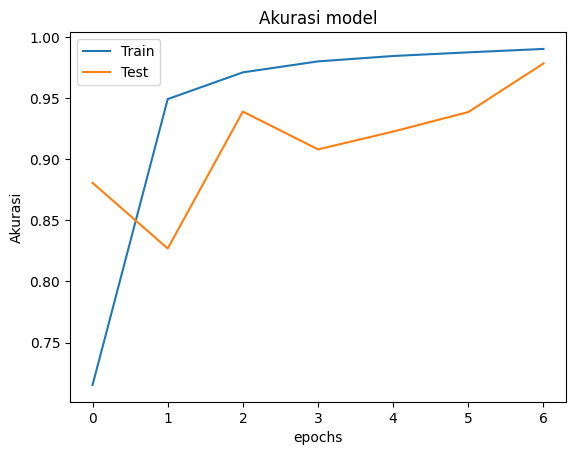

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi model')
plt.ylabel('Akurasi')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

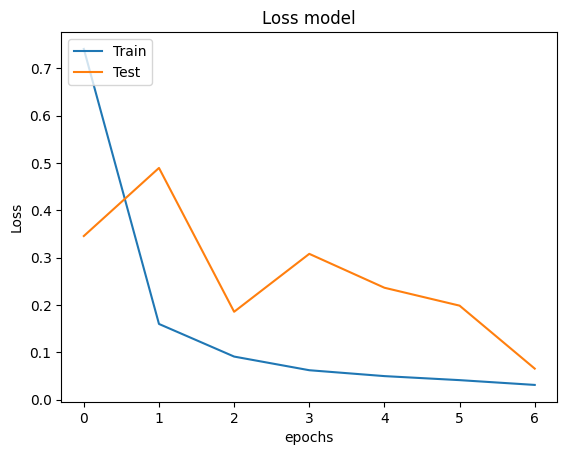

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss model')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

24253876